<a href="https://colab.research.google.com/github/strawndri/tmcc-voculary/blob/feature%2Freconhecimento-texto/reconhecimento-texto/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Instalações e importações

## 1.1 Bibliotecas

In [1]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install langdetect

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (13.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [2]:
import pytesseract as pt
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from langdetect import detect

In [3]:
!mkdir tessdata

In [4]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2023-09-01 12:27:25--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2023-09-01 12:27:25--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2023-09-01 12:27:25--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awa

## 1.2 Imagens

In [39]:
artigo = 'imagens/artigo.png'
codigo = 'imagens/codigo.png'
nota_fiscal = 'imagens/nota_fiscal.png'
pagina = 'imagens/pagina.png'
pagina_2 = 'imagens/pagina_2.png'

# 2 Tratamento de imagens

In [6]:
def realcar_detalhes(imagem):
    img_redimensionada = cv2.resize(imagem, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    img_suavizada = cv2.GaussianBlur(img_redimensionada, (5, 5), 0)
    img_detalhes = 12 * cv2.subtract(img_redimensionada, img_suavizada)

    return cv2.add(img_redimensionada, img_detalhes)

In [7]:
def ajustar_brilho(imagem, threshold=128, alpha=1.5, beta=50):
    if np.mean(imagem) < threshold:
        return cv2.convertScaleAbs(imagem, alpha=alpha, beta=beta)
    return imagem

In [8]:
def binarizar(imagem):
    _, img_threshold = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if cv2.countNonZero(img_threshold) < (img_threshold.size / 2):
        return 255 - img_threshold
    return img_threshold

In [44]:
def calcula_angulo(imagem):
  bordas = cv2.Canny(imagem, 50, 150, apertureSize = 3)
  linhas = cv2.HoughLines(bordas, 1, np.pi/180, 200)
  if linhas is None:
    return 0

  angulos = []
  for _, theta in linhas[:, 0]:
    angulo = np.degrees(theta) - 90
    if angulo < 0:
      angulo += 180
    angulos.append(angulo)
    return np.median(angulos)

def rotaciona_imagem(imagem, angulo):
  (h, w) = imagem.shape[:2]
  centro = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(centro, angulo, 1.0)
  rotacionada = cv2.warpAffine(imagem, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
  return rotacionada

def ajustar_orientacao(imagem):
  imagem = cv2.imread(imagem)
  angulo = calcula_angulo(imagem)
  imagem_corrigida = rotaciona_imagem(imagem, angulo)
  return imagem_corrigida

In [50]:
def remove_sombra(imagem):

  rgb_planes = cv2.split(imagem)

  result_norm_planes = []

  for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    result_norm_planes.append(norm_img)

    result_norm = cv2.merge(result_norm_planes)

    return result_norm

# 3 Detecção e extração de textos

In [9]:
def determinar_psm(imagem):
    pixels_pretos = imagem.size - cv2.countNonZero(imagem)
    proporcao_preto = pixels_pretos / imagem.size

    if proporcao_preto > 0.2:
        return '6'
    else:
        return '1'

In [10]:
def detectar_idioma(imagem):
    codigos = {
        'en': 'eng',
        # 'es': 'spa',
        # 'fr': 'fra',
        # 'id': 'ind',
        # 'it': 'ita',
        # 'ja': 'jpn',
        'pt': 'por',
        # 'th': 'tha',
        # 'uk': 'ukr',
        # 'zh-cn': 'chi_sim',
        # 'zh-tw': 'chi_tra'
    }

    try:
        cod_idioma = codigos[detect(pt.image_to_string(imagem))]
    except:
        cod_idioma = 'eng'

    return cod_idioma

In [54]:
def extrair_texto(imagem):

    imagem = ajustar_orientacao(imagem)
    imagem = realcar_detalhes(imagem)
    imagem = ajustar_brilho(imagem)
    img_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    img_binarizada = binarizar(img_cinza)

    psm_valor = determinar_psm(img_binarizada)
    cod_idioma = detectar_idioma(img_binarizada)

    resultado = pt.image_to_data(img_binarizada,
                               lang=cod_idioma,
                               config=f'--tessdata-dir tessdata --psm {psm_valor}',
                               output_type=pt.Output.DICT)

    texto_filtrado = [resultado['text'][i] for i in range(len(resultado['conf'])) if int(resultado['conf'][i] >= min_conf)]
    texto = ' '.join(texto_filtrado)

    return img_binarizada, texto

# 4 Testes de OCR

In [14]:
min_conf = 40 #@param {type: 'slider', min:0,max: 100}

## 4.1 Trecho de artigo

In [ ]:
imagem, texto = extrair_texto(artigo)
cv2_imshow(imagem)
print(texto)

## 4.2 Trecho de código do Visual Studio Code

In [ ]:
imagem, texto = extrair_texto(codigo)
cv2_imshow(imagem)
print(texto)

## 4.3 Nota fiscal

In [ ]:
imagem, texto = extrair_texto(nota_fiscal)
cv2_imshow(imagem)
print(texto)

## 4.4 Página de um livro

In [ ]:
imagem, texto = extrair_texto(pagina)
cv2_imshow(imagem)
print(texto)

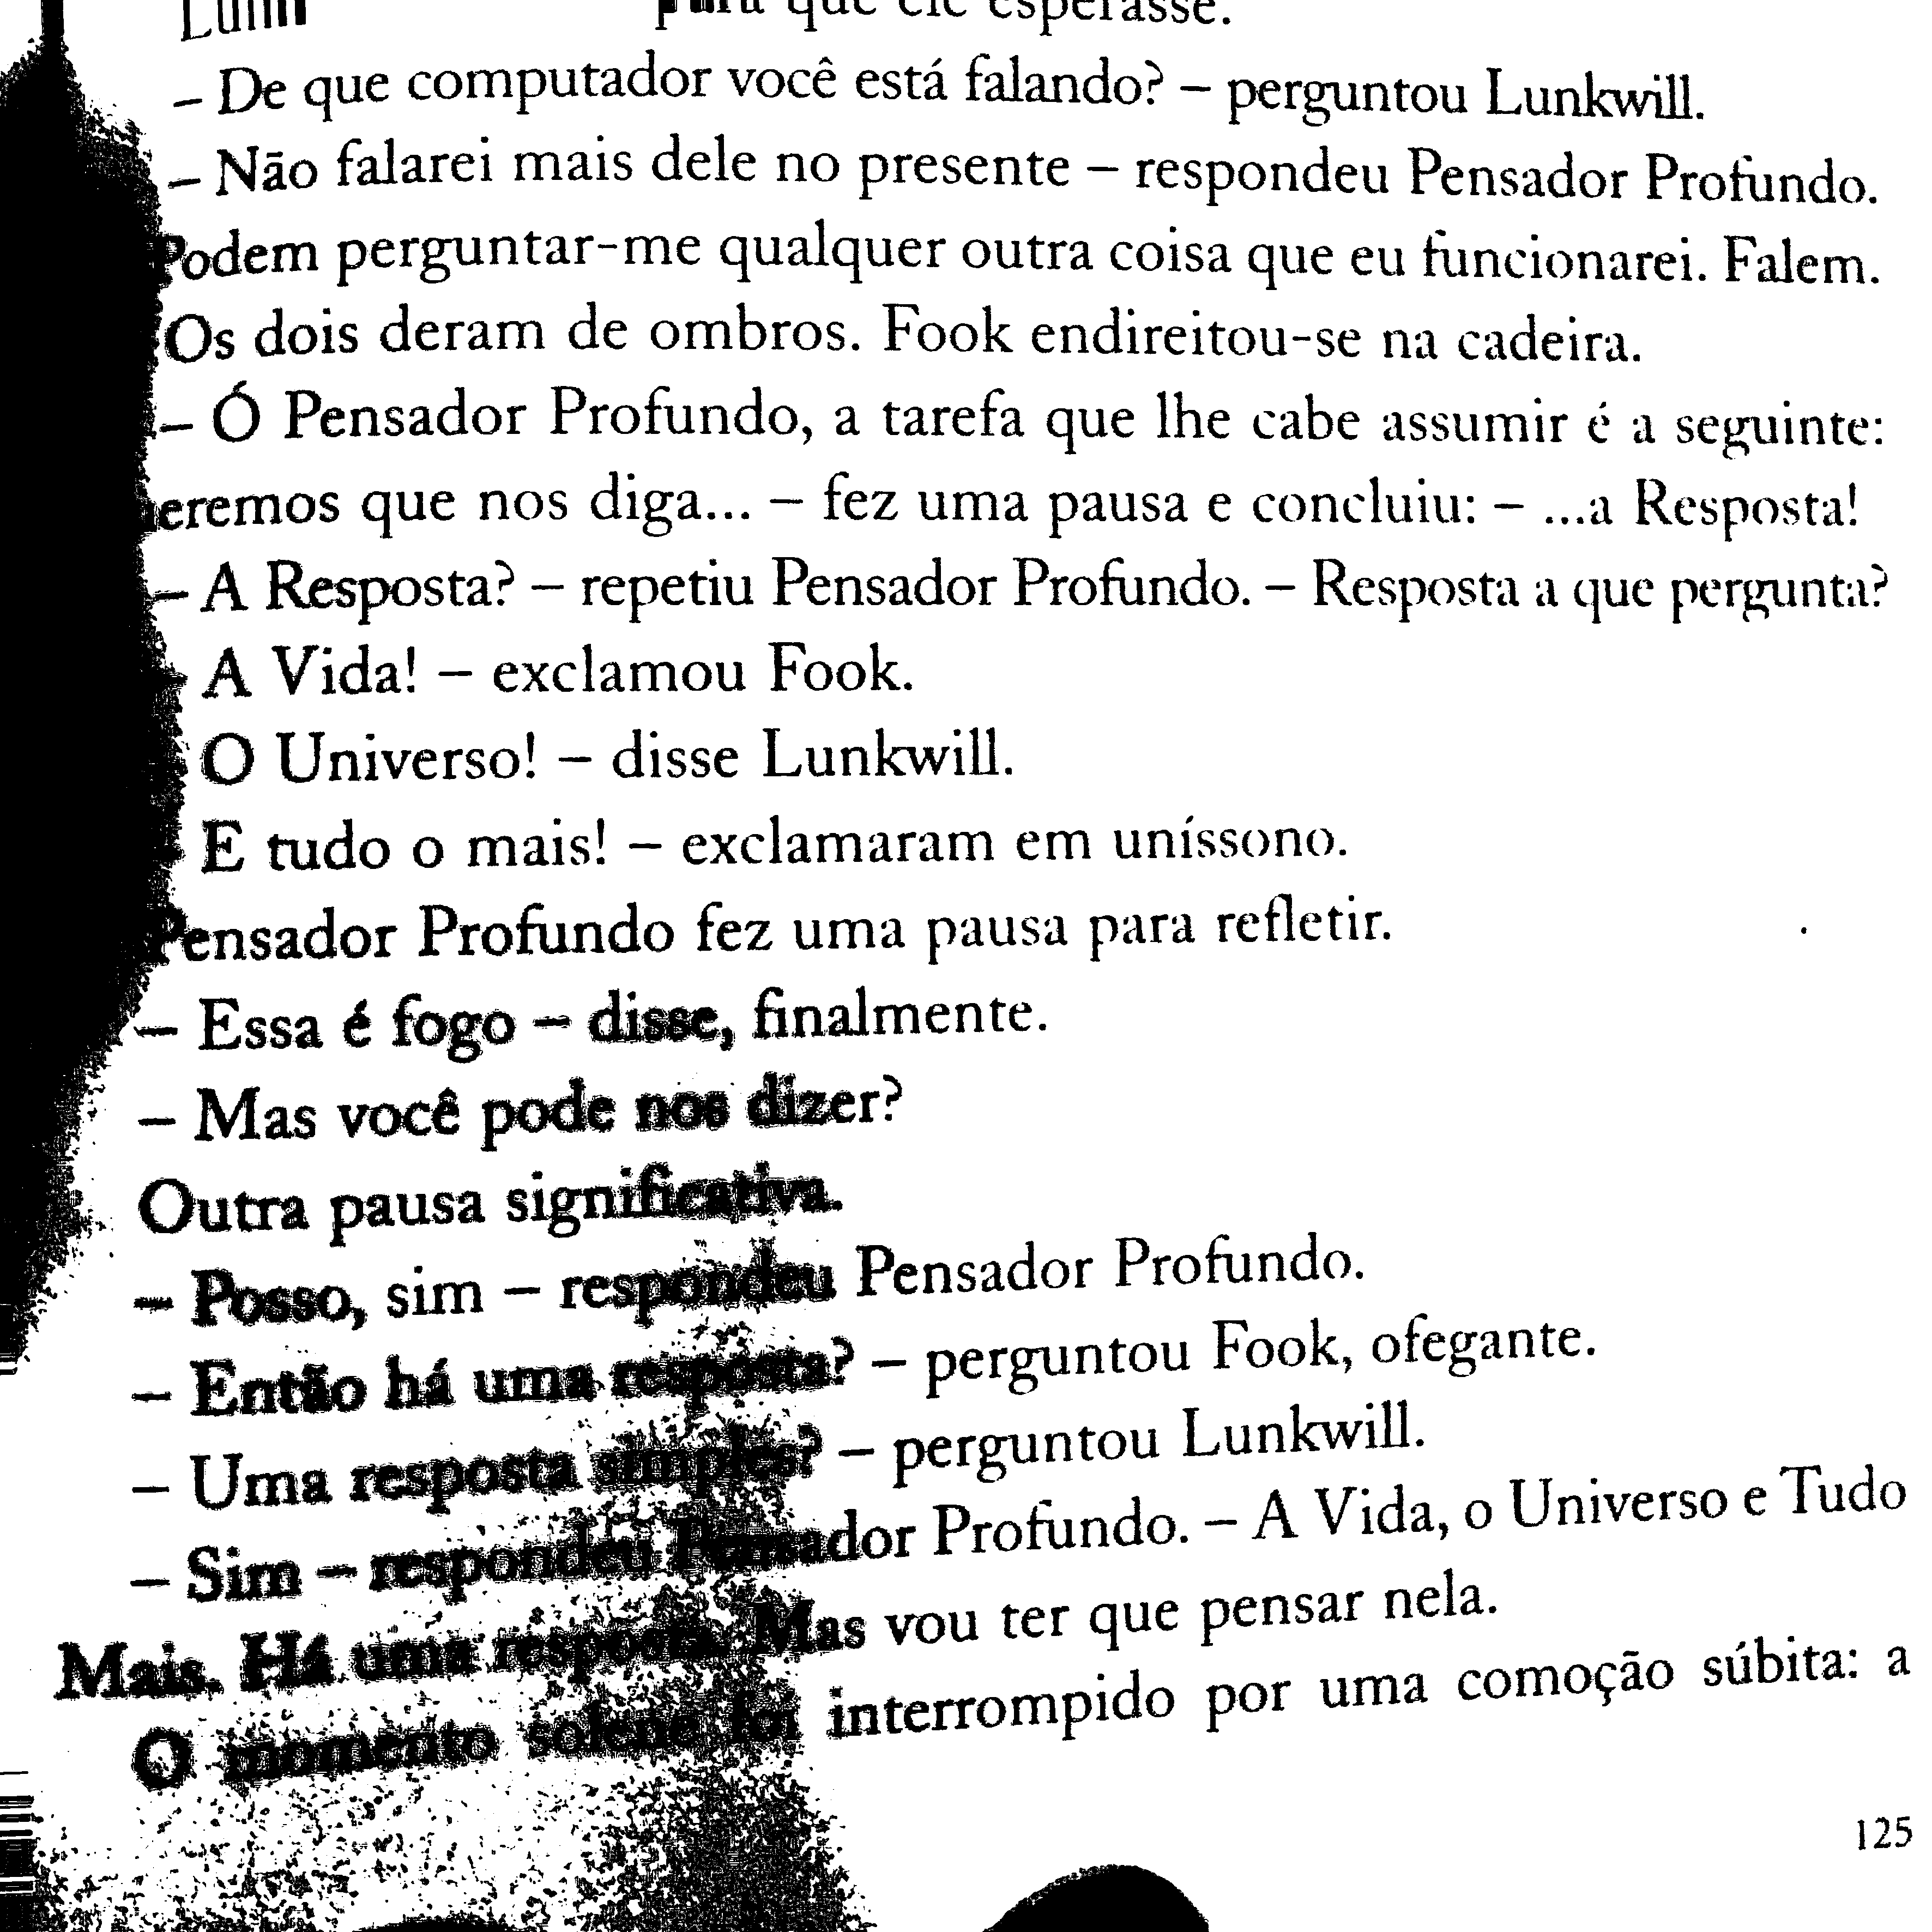

viv L. - De que computador você está falando? — perguntou Lunkwill . Não falarei mais dele no presente — responãeu Pem;ldor P o qualquer outra coisa que eu fº;“; dois deram de ombros. Fook endireitou-se na Ó Pensador Profundo, a tarefa que lhe cabe assu;nir é .1 seguinte: peremos que nos diga... — fez uma pausa e concluiu: — ...a Resg:qta'e. A Resposta? — repetiu Pensador Profundo. — Resposta a que ªp | ? À Vida! — exclamou Fook. Universo! — disse Lunkwill. E tudo o mais! — exclamaram em unissono. Profundo fez uma pausa para refletir. lisse, finalmente.                                        Pensador Profundo. ' ? — perguntou Fook, ofegante. — perguntou Lunkwill. Profundo. — À Vida, o Universo e Tudo g vou ter que pensar nela. interrompido por uma comoção súbita: a 125


In [53]:
imagem, texto = extrair_texto(pagina_2)
cv2_imshow(imagem)
print(texto)